<a href="https://colab.research.google.com/github/ddekun/Data_analysis_algorithms/blob/lesson6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Алгоритмы анализа данных

## Урок 6. Градиентный бустинг (AdaBoost)

### Домашнее задание
Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.
Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).
Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

**Используем один из "игрушечных" датасетов из той же библиотеки.**

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

**Разделим выборку на обучающую и тестовую в соотношении 75/25.**

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

**Напишем функцию, реализующую предсказание в градиентном бустинге.**

In [5]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

**В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.**

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

**Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).**

In [7]:
def residual(y, z):
    return - (z - y)

**Реализуем функцию обучения градиентного бустинга.**

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

**Для реализованной модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.**

In [10]:
from tqdm import tqdm


eta = 1
max_depths = range(1, 11)


def plot_different_max_depths(n_trees=3, max_depths=max_depths):
    train_errors_depths = []
    test_errors_depths = []

    for max_depth in tqdm(max_depths):
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])


    print(f'Количество деревьев в бустинге {n_trees}')
    plt.plot(range(len(max_depths)), train_errors_depths, label='train_error')
    plt.plot(range(len(max_depths)), test_errors_depths, label='test_error')
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.legend()

100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Количество деревьев в бустинге 3


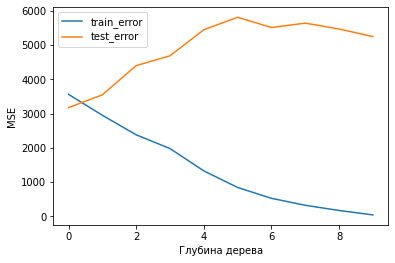

In [11]:
plot_different_max_depths(max_depths=max_depths, n_trees=3)

100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

Количество деревьев в бустинге 10


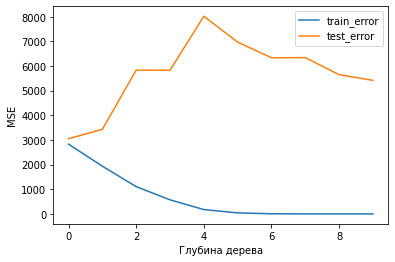

In [12]:
plot_different_max_depths(max_depths=max_depths, n_trees=10)

In [15]:
eta = 1
n_trees = range(1, 10, 1)


def plot_different_num_trees(n_trees=n_trees, max_depth=3):
    train_errors_trees = []
    test_errors_trees = []

    for n in tqdm(n_trees):
        _, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])


    print(f'Максимальная глубина дерева {max_depth}')
    plt.plot(n_trees, train_errors_trees, label='train_error')
    plt.plot(n_trees, test_errors_trees, label='test_error')
    plt.xlabel('Количество алгоритмов в бустинге')
    plt.ylabel('MSE')
    plt.xticks(n_trees, n_trees)
    plt.legend()

100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Максимальная глубина дерева 3


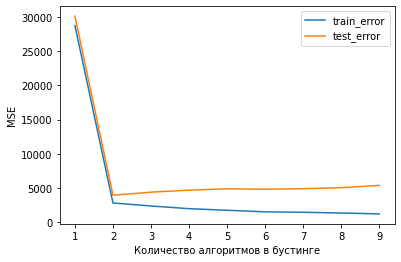

In [16]:
plot_different_num_trees(n_trees=n_trees, max_depth=3)

100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Максимальная глубина дерева 5


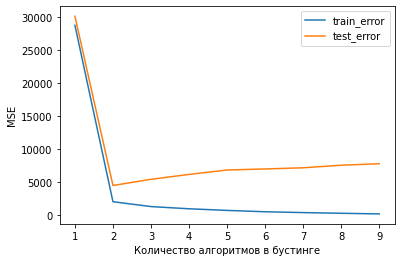

In [17]:
plot_different_num_trees(n_trees=n_trees, max_depth=5)

100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


Максимальная глубина дерева 10


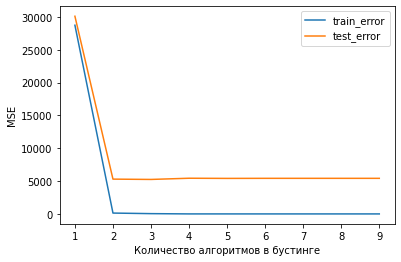

In [18]:
plot_different_num_trees(n_trees=n_trees, max_depth=10)

Вывод:
1. С увеличением количества деревьев ошибка в тренировочной и тестовой выборке уменьшается.
2. С увеличением глубины дерева более 3 происходит увеличение ошибки на тестовой выборке, а величина ошибки на тренировочной выборке существенно не уменьшается. При этом происходит значительное замедление работы алгоритма.